In [110]:
# Import packages
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge
from shapely.geometry import box, mapping
import json

import geopandas as gpd
import pandas as pd
import numpy as np

import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import Model
from keras.utils import to_categorical, plot_model, model_to_dot

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


import ee
import geemap

import os
from datetime import datetime
import folium

import xarray
from shapely.geometry import JOIN_STYLE, Polygon, MultiPolygon

import json

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error

# CART
from sklearn.tree import DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost
from xgboost import XGBRegressor

In [122]:
ee.Initialize()

SEED = 2024
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']
LABEL = ['type']
N_CLASSES = 4
CLASSES = [0, 1, 2, 3]

CLASS_VALUES = {
    'urban': 0, 
    'deep_ocean': 1, 
    'shallow_waters': 2, 
    'rural': 3
}

class_labels = {v: k for k, v in CLASS_VALUES.items()}

PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080']
NUM_SAMPLES_PER_CLASS = 800

## Load Data

In [3]:
# Load the Cuba territorial seas shapefile (inside the data folder) using geopandas
cuba_territorial_seas = gpd.read_file(os.path.join('data', 'eez_12nm.zip'))


# The shapefile has only the shape of the territorial seas of Cuba, so we need to fill in the ring to capture
# the whole island.
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

cuba_territorial_seas = cuba_territorial_seas.geometry.apply(lambda p: close_holes(p))

In [4]:
# Define the image collection and geometry
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")

# Convert GeoPandas object to Earth Engine geometry
cuba_json = cuba_territorial_seas.to_json()

geometry_cuba = ee.FeatureCollection(json.loads(cuba_json))

## Filter Data

In [5]:
# Define a function to mask clouds for Landsat 8 images
def mask_clouds(image):
    L8cloudShadowBitMask = 1 << 3
    L8cloudsBitMask = 1 << 4
    L8Qa = image.select('QA_PIXEL')
    L8mask = L8Qa.bitwiseAnd(L8cloudShadowBitMask).eq(0) \
             .And(L8Qa.bitwiseAnd(L8cloudsBitMask).eq(0))
    return image.updateMask(L8mask)

In [6]:
geometry_idlj = ee.Geometry.Polygon(
    [[[-83.21494438818296,21.356673185906914],
      [-82.5032363193353,21.356673185906914],
      [-82.5032363193353,21.93872306614785],
      [-83.21494438818296,21.93872306614785]]])

In [7]:
# Filter the Landsat images
landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

# Define start and end dates
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-12-31')

# Filter by date
landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

# Get median image, only for the geometry of cuba, and for bands with 30m resolution
median_image = landsat_cuba.median().clip(geometry_cuba).select(FEATURES)

# Get median image, only for the geometry of Isla de la Juventud
# We will use this image for visually displaying the model results
median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

# Display the map
mapid = median_image.getMapId({'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']})

In [8]:
# Create a Folium map object
map = folium.Map(location=[22, -80], zoom_start=7)

# Add the Landsat image layer
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Landsat Image',
).add_to(map)

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map

## Create Isla de La Juventud Cutout

We will also save it as a tif file to be able to work with it as a rasterio object.

In [9]:
# Function to split geometry into smaller subregions
def split_geometry(geometry, num_parts):
    bounds = geometry.bounds().getInfo()
    # Extracting bounding coordinates
    xmin = bounds['coordinates'][0][0][0]
    ymin = bounds['coordinates'][0][0][1]
    xmax = bounds['coordinates'][0][2][0]
    ymax = bounds['coordinates'][0][2][1]
    width = (xmax - xmin) / num_parts
    height = (ymax - ymin) / num_parts

    subgeometries = []
    for i in range(num_parts):
        for j in range(num_parts):
            subgeometry = box(xmin + i * width, ymin + j * height,
                              xmin + (i + 1) * width, ymin + (j + 1) * height)
            subgeometries.append(subgeometry)

    return subgeometries

In [10]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_path = os.path.join(temp_dir, "ildj_median_2023_merged.tif")
if not os.path.exists(output_path):
    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_idlj, num_parts=3)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
        print(f"Exporting {output_filename}...")

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif") for i in range(len(subgeometries))]
    datasets = [rasterio.open(file) for file in output_files]
    merged, transform = merge(datasets)

    # Close the datasets
    for dataset in datasets:
        dataset.close()

    # Update the metadata
    profile = datasets[0].profile
    profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

    # Output merged image
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(merged)

    # Delete smaller TIFF files
    for file in output_files:
        os.remove(file)
else:
    print("Found existing ildj_median_2023_merged.tif file. Using that instead.")

Found existing ildj_median_2023_merged.tif file. Using that instead.


In [11]:
median_image_raster = rasterio.open(output_path)
height = median_image_raster.height
width = median_image_raster.width
shape = (height, width)

## Set up Samples

In [137]:
# Check if samples file exists
samples_path = os.path.join(temp_dir, "cuba_samples.csv")
if not os.path.exists(samples_path):
    print("Unable to find Cuba samples file. Creating a new one, this may take a while...")

    # Load cuba_samples_polygons.geojson as an Earth Engine FeatureCollection
    cuba_samples = geemap.geojson_to_ee(os.path.join('data', 'cuba_samples_polygons.geojson'))

    # Create an empty list to store the results
    result_list = []

    # Iterate through each 'type' in cuba_samples
    types = cuba_samples.aggregate_array("type").distinct().getInfo()

    for type_value in types:
        print("Sampling: ", type_value)
        # Filter cuba_samples by the current type
        samples_filtered = cuba_samples.filter(ee.Filter.eq("type", type_value))
        
        # Sample the median image at the locations of the filtered samples
        sampled_image = median_image.addBands(ee.Image.constant(CLASS_VALUES[type_value]).rename('int_type')).sample(
            region=samples_filtered.geometry(),
            scale=30,
            numPixels=NUM_SAMPLES_PER_CLASS,  # Specify the number of pixels to sample
            geometries=True,
            seed=SEED
        )
        
        # Add the sampled image to the result list
        result_list.append(sampled_image)

    # Merge all the results into a single ImageCollection
    extract = ee.FeatureCollection(result_list).flatten()

    # -----------------------------------------------------------

    print("Extracting data...")
    # Convert extract to a pandas DataFrame
    samples = geemap.ee_to_df(extract)
    
    # Add column 'int_type' that gives an integer value to each class
    samples['type'] = samples['int_type'].map(class_labels)

    samples = samples.sample(frac = 1, random_state=SEED) # Shuffle data

    # Save the samples to a CSV file in the temporary directory
    samples.to_csv(os.path.join(temp_dir, "cuba_samples.csv"), index=False)

    print("Cuba samples file created successfully.")

else:
    print("Found existing Cuba samples file. Using that instead.")
    samples = pd.read_csv(samples_path)

samples.head()

Unable to find Cuba samples file. Creating a new one, this may take a while...
Sampling:  urban
Sampling:  deep_ocean
Sampling:  shallow_waters
Sampling:  rural
Extracting data...
Cuba samples file created successfully.


,B1,B2,B3,B4,B5,B6,B7,B9,int_type,type
3075,0.118029,0.092481,0.076673,0.045977,0.348940,0.125165,0.044208,0.001141,3,rural
284,0.170383,0.157695,0.153561,0.170483,0.254113,0.289963,0.221475,0.000739,0,urban
1978,0.194242,0.190913,0.136710,0.060941,0.035327,0.024119,0.018371,0.001039,2,shallow_waters
2524,0.124978,0.101727,0.087597,0.061029,0.304628,0.194059,0.094725,0.001236,3,rural
1479,0.141114,0.109805,0.062376,0.040879,0.027439,0.018332,0.014389,0.000667,1,deep_ocean


In [138]:
# Split data into training and testing (80% training, 20% testing)
train = samples.sample(frac=0.8, random_state=SEED)
test = samples.drop(train.index)

# Split between features and label
train_features = train[FEATURES]
train_label = train[['int_type']]
test_features = test[FEATURES]
test_label = test[['int_type']]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), num_classes=N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), num_classes=N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (2514, 8, 1)
Test features: (629, 8, 1)
Train label: (2514, 5)
Test label: (629, 5)


## CART Model

We will use GridSearchCV to find the best parameters for our model.

In [139]:
# Modify train and test features to be 2D arrays (for CART and Random Forest)
train_x = train_input.reshape(train_input.shape[0], train_input.shape[1])
train_y = train_output.reshape(train_output.shape[0], train_output.shape[1])

test_x = test_input.reshape(test_input.shape[0], test_input.shape[1])
test_y = test_output.reshape(test_output.shape[0], test_output.shape[1])

In [140]:
# a CART using default settings
cart_default = DecisionTreeClassifier(random_state=SEED)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 8


In [141]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2, 4, 6, 8, 10], 'min_samples_split':[2,4,6,8,10]}

dt = DecisionTreeClassifier(random_state=SEED)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 8, 'min_samples_split': 6}
The best score is: 
0.9928413582251512


In [142]:
dt_final = DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
dt_final.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=8, min_samples_split=6, random_state=2024)

In [143]:
print("R2 on the training data:")
print(dt_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(dt_final.score(X=test_x, y=test_y))

R2 on the training data:
0.9972155926809865
R2 on the testing data:
0.9888712241653418


In [144]:
# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

Tree depth:8
Number of leaves:20


## Random Forest Model

In [145]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2, 4, 6, 8, 10], 'min_samples_split':[2,4,6,8,10]}

rf = RandomForestClassifier(random_state=SEED)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 4}
The best score is: 
0.9968182934266908


In [146]:
rf_final = RandomForestClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
rf_final.fit(train_x, train_y)

RandomForestClassifier(max_depth=10, min_samples_split=4, random_state=2024)

In [147]:
print("R2 on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R2 on the training data:
1.0
R2 on the testing data:
0.9968203497615262


## XGBoost Model

In [148]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2, 4, 6, 8, 10], 'n_estimators':[50,100,150,200,250]}

xgb = XGBRegressor(random_state=SEED)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

The best parameter value is: 
{'max_depth': 4, 'n_estimators': 200}
The best score is: 
0.7897808827968479


In [149]:
xgb_final = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=SEED)
xgb_final.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

In [150]:
print("R2 on the training data:")
print(xgb_final.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(xgb_final.score(X=test_x, y=test_y))

R2 on the training data:
0.799994949591228
R2 on the testing data:
0.7856241532967769


## Neural Network Model

### Make Model

In [151]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 1

# Make sequential model
nn_model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 7, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 6, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 4, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,949 (324.02 KB)

 Trainable params: 82,949 (324.02 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [152]:
# Compline the model
nn_model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',  # Updated the loss parameter
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = nn_model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.2202 - loss: 1.6003 - val_accuracy: 0.2703 - val_loss: 1.5753
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2732 - loss: 1.5587 - val_accuracy: 0.2703 - val_loss: 1.5212
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.2810 - loss: 1.4906 - val_accuracy: 0.2703 - val_loss: 1.4332
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.2767 - loss: 1.4006 - val_accuracy: 0.2703 - val_loss: 1.3265
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2914 - loss: 1.2944 - val_accuracy: 0.3418 - val_loss: 1.2138
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3168 - loss: 1.1894 - val_accuracy: 0.5580 - val_loss: 1.1047
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4513 - loss: 1.0926 - val_accuracy: 0.7536 - val_loss: 0.9985
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5523 - loss: 0.9926 - val_accuracy: 0.7711 - 

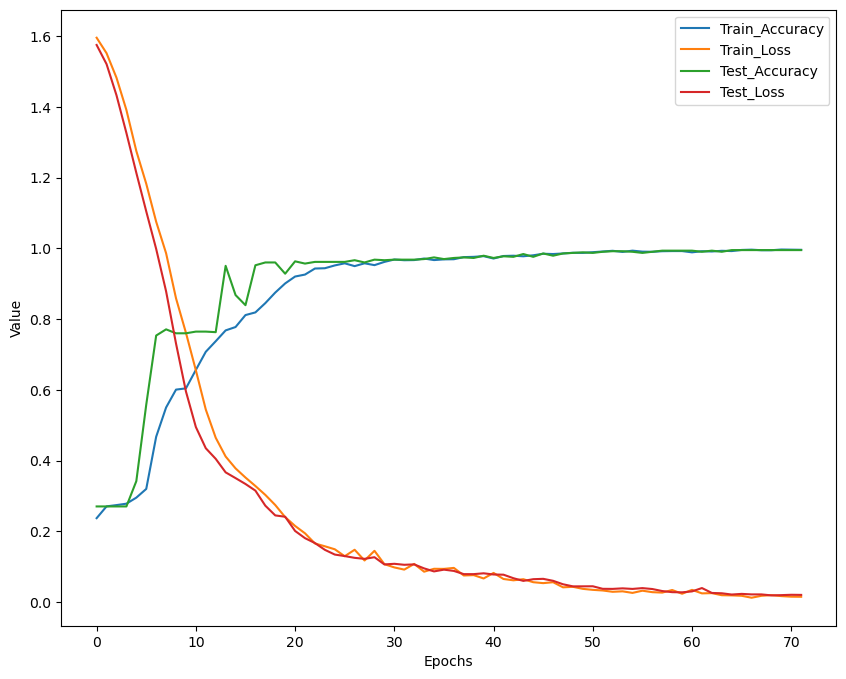

In [153]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

## Run Models on Isla de La Juventud

In [154]:
src_array = median_image_raster.read()
bands = median_image_raster.count

In [155]:
row_per_pixel = src_array.reshape([bands,-1]).T
columns = [f'band_{n}' for n in range(1,bands+1)]
row_per_pixel_df  = pd.DataFrame(row_per_pixel,columns=columns)

In [156]:
dt_prediction = dt_final.predict(row_per_pixel_df).astype('float64')

dt_prediction = np.argmax(dt_prediction, 1)
dt_prediction = dt_prediction.reshape(shape[0], shape[1])

c:\Users\juane\miniforge3\envs\satellite_class_3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [157]:
rf_prediction = rf_final.predict(row_per_pixel_df).astype('float64')

rf_prediction = np.argmax(rf_prediction, 1)
rf_prediction = rf_prediction.reshape(shape[0], shape[1])

c:\Users\juane\miniforge3\envs\satellite_class_3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [158]:
xgb_prediction = xgb_final.predict(row_per_pixel_df).astype('float64')
xgb_prediction = np.argmax(xgb_prediction, 1)
xgb_prediction = xgb_prediction.reshape(shape[0], shape[1])

In [159]:
# NN Prediction requires slightly different steps due to the model's input shape
image_input = []
for x in range(8):
  image_input.append(median_image_raster.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

# Predict
nn_prediction = nn_model.predict(image_input, batch_size=4096*20)
nn_prediction = np.argmax(nn_prediction, 1)
nn_prediction = nn_prediction.reshape(shape[0], shape[1])

70/70 ━━━━━━━━━━━━━━━━━━━━ 128s 795ms/step


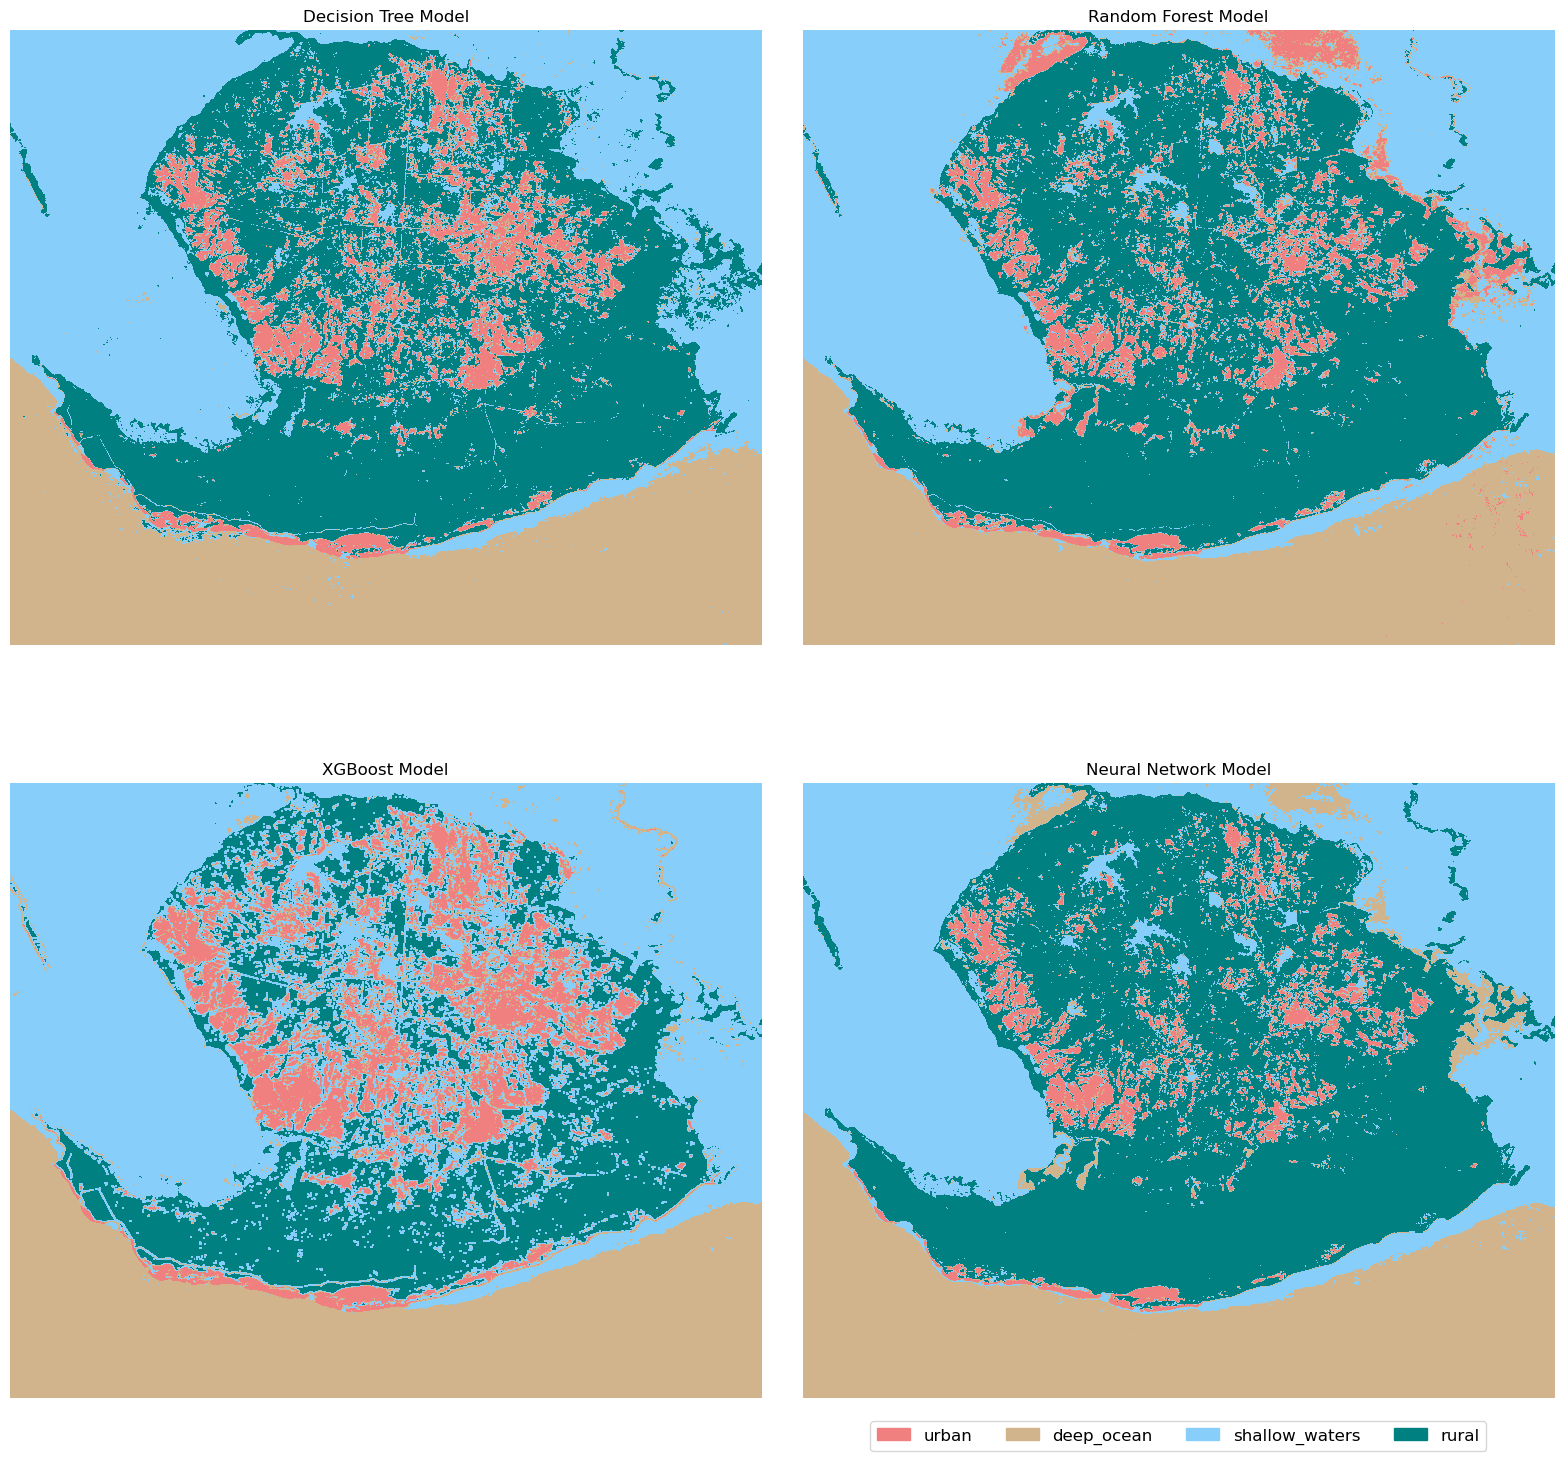

In [160]:
models = {"Decision Tree": dt_prediction, "Random Forest": rf_prediction, "XGBoost": xgb_prediction, "Neural Network": nn_prediction}

# Create a custom colormap with class labels
colors = [PALETTE[i] for i in CLASSES]
cmap = ListedColormap(colors)

# Plotting the results of each model in separate subplots
num_models = 4
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(models.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Plot the results of the current model
    ax.imshow(value, cmap=cmap)
    
    # Add title for the subplot
    ax.set_title(f"{key} Model")
    
    # Remove axis
    ax.axis('off')

# Create a custom legend
legend_handles = [mpatches.Patch(color=PALETTE[i], label=class_labels[i]) for i in CLASSES]
plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(CLASSES), fontsize='12')

plt.tight_layout()
plt.show()